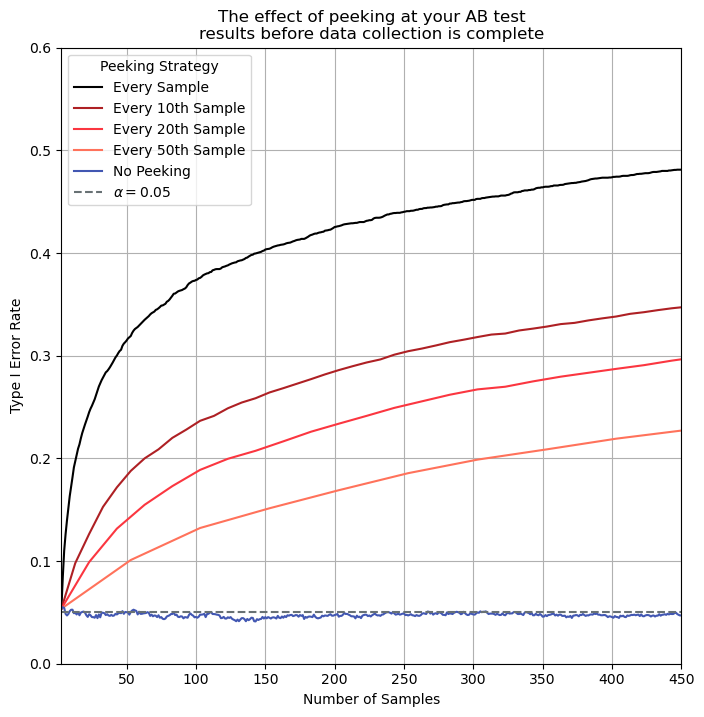

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from vis import COLORS, save_figure

np.random.seed(123)

"""
Simulate 5000 experiments with 500 samples each. There is no statistical
difference in the mean of the sampled data from zero (our Null Hypothesis)
"""
n_samples_per_simulation, n_simulations = 500, 5000
real_mean = 0
sampling_distribution = stats.norm(loc=real_mean)
simulations = sampling_distribution.rvs(
    size=(n_samples_per_simulation, n_simulations)
)

# Simulate many hypothesis tests, increasing the sample size for each
p_values = []
n_samples = []
min_samples = 3  # Minimum samples used to run a t-test
for n_samples_used in range(min_samples, n_samples_per_simulation):
    n_samples.append(n_samples_used)

    # p-values obtained from one-sample t-test
    p_values.append(
        stats.ttest_1samp(simulations[:n_samples_used], 0., axis=0).pvalue
    )

# Make null-hypothesis decisions based on p-values
alpha = .05  # Researcher-defined acceptable Type I error rate
decisions = np.array(p_values) <= alpha

"""
We simulate peeking by denoting all observations that follow
observing an initial positive result to also be considered positive.
This is equivalent to not collecting any more data.
"""
# Simulate peeking every N-th sample strategy
peeking_strategy = [1, 10, 20, 50]
peeking_strategy_colors = [
    "black",
    COLORS.dark_red,
    COLORS.red,
    COLORS.salmon
]
plt.subplots(figsize=(8, 8))
for ci, peek_every_nth in enumerate(peeking_strategy):

    intermitten_peeking_decisions = decisions[::peek_every_nth].cumsum(axis=0) >=1
    intermitten_peeking_type_I_error_rate = intermitten_peeking_decisions.mean(axis=1)

    # Add plot for this strategy
    label = 'Every Sample' if peek_every_nth == 1 \
        else f'Every {peek_every_nth}th Sample'
    plt.plot(
        n_samples[::peek_every_nth],
        intermitten_peeking_type_I_error_rate,
        color=peeking_strategy_colors[ci],
        label=label
    )

"""
We simulate no peaking as just the average Type I error
rate across all simulations without any results-dependent
screening.
"""
type_I_error_rate = decisions.mean(axis=1)  
plt.plot(n_samples, type_I_error_rate, color=COLORS.blue, label='No Peeking')
plt.axhline(
    alpha,
    color=COLORS.gray,
    linestyle='--', 
    label=r'$\alpha={:0.2f}$'.format(alpha)
)

plt.ylim(0, .6)
plt.xlim(min_samples, n_samples_per_simulation - peeking_strategy[-1])
plt.xlabel("Number of Samples")
plt.ylabel("Type I Error Rate")
plt.title(
    "The effect of peeking at your AB test\n"
    "results before data collection is complete"
)
plt.legend(title="Peeking Strategy")
plt.grid();
save_figure("p-hacking-data-peeking", "peeking-every")